In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
register_matplotlib_converters()
sns.set_style('darkgrid')
plt.rc('figure', figsize=(8, 4))
plt.rc('font', size=12)

# Data

In [3]:
dfs = pd.read_csv('data/stores.csv', low_memory=False)
dft = pd.read_csv('data/transactions.csv', low_memory=False)
dfu = pd.read_csv('data/users.csv', low_memory=False)

### Add transaction data

In [4]:
# Add month of transaction
dft['month'] = pd.to_datetime(dft.event_occurrence).dt.to_period('M')

In [5]:
# Add store data to transaction
dft = dft.merge(
    dfs[['id', 'nam', 'category']].rename(columns={'id': 'store_id'}),
    on='store_id',
    how='left'
)

In [6]:
dft.head(2)

,id,user_id,store_id,event_occurrence,amount,month,nam,category
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,2020-01,Saitama Ken,コンビニ
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,2020-01,Gunma Ken,ショッピング


# Forecast User
(2) Forecast GMV for each user for the month of January 2022

### Calculate GMV per user per month

In [7]:
def fill_missing_months(ts: pd.Series, inplace: bool = False) -> pd.Series:
    """Fill missing months with 0 after the month with first order."""
    if not inplace:
        ts = ts.copy()

    i = ts.notnull().argmax()
    ts.iloc[i:].fillna(0, inplace=True)
    
    if not inplace:
        return ts

dfd = (
    dft.groupby(['user_id', 'month'])['amount'].sum()
    .unstack(1)
    .apply(fill_missing_months, axis=1)
    .stack()
    .to_frame('gmv')
    .reset_index()
)

In [8]:
# Add forecast month, to calculate lag and rolling features
df_for = pd.DataFrame({
    'user_id': dfd.user_id.unique(),
    'month': pd.Period('2022-01'),
    'gmv': np.nan
})
dfd = pd.concat([dfd, df_for], ignore_index=True)

In [9]:
dfd.head(2)

,user_id,month,gmv
0,00073cc2-c801-c67c-d039-fca63c78c6a9,2020-11,309.0
1,00073cc2-c801-c67c-d039-fca63c78c6a9,2020-12,18318.0


In [10]:
dfd.tail(2)

,user_id,month,gmv
150009,ffed71e5-7c13-30cf-f1eb-63b80f7f6326,2022-01,NaN
150010,fff93376-ba79-395d-29aa-707efa359a89,2022-01,NaN


### Feature Engineering

In [11]:
# Add user age and gender
dfd = dfd.merge(dfu.rename(columns={'id': 'user_id'}), on='user_id', how='left')

In [12]:
# Add passage of time
dfd['time_elapsed'] = dfd.month.astype('datetime64[ns]').values.astype(np.int64)/(10**9)

In [13]:
# Add time lag features
lags = range(1, 13)
for lag in lags:
    col_name = f'gmv_lag_{lag}'
    dfd[col_name] = dfd.groupby(['user_id'])['gmv'].shift(lag)

In [14]:
# Add rolling mean for 3 and 6 month windows
for roll in [3, 6]:
    col_name = f'gmv_roll_mean_{roll}'
    dfd[col_name] = dfd.groupby(['user_id'])['gmv'].shift(1).rolling(roll).mean()

In [15]:
# GMV per shop category
df_cat = (
    dft
    .groupby(['user_id', 'month', 'category'])['amount'].sum()
    .unstack(1)
    .apply(fill_missing_months, axis=1)
    .stack()
    .unstack('category')
    .reset_index()
)
dfd = dfd.merge(df_cat, on=['user_id', 'month'], how='left')

# Add GMV of shop category of previous month
cat_cols = dft['category'].unique().tolist()
lag_cols = [f'{x}_lag_1' for x in cat_cols]
dfd[lag_cols] = dfd.groupby(['user_id'])[cat_cols].shift(1)
dfd.drop(columns=cat_cols, inplace=True)

# Check GMV and category sum of previous month
(dfd.gmv_lag_1.fillna(0) - dfd[lag_cols].sum(axis=1)).sum()

0.0

In [16]:
# Convert object dtype to categorical for LightGBM
dfd['user_id'] = dfd['user_id'].astype('category')
dfd['gender'] = dfd['gender'].astype('category')

In [17]:
# No need to impute missing values because LightGBM can automatically deal with NaN

In [18]:
dfd.sample(3).T

,70495,99413,130893
user_id,840c9767-5c47-c5a2-27dd-9d1fecb25622,b6f6fec4-0001-8698-c34e-3dc12da7ca31,eec8cf25-a611-2120-1828-99714492b0fb
month,2021-01,2021-06,2020-02
gmv,37637.0,21390.0,13889.0
gender,M,NaN,F
age,60.0,82.0,56.0
time_elapsed,1609459200.0,1622505600.0,1580515200.0
gmv_lag_1,31718.0,15593.0,15939.0
gmv_lag_2,40202.0,9187.0,NaN
gmv_lag_3,20734.0,8121.0,NaN
gmv_lag_4,26634.0,19619.0,NaN


### Plot user example

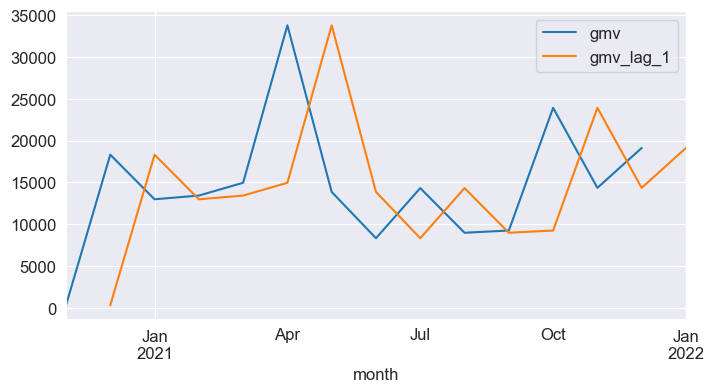

In [19]:
users = dfd.user_id.unique()
tsu = dfd[dfd.user_id == users[0]].set_index('month')['gmv']
tsu_lag_1 = dfd[dfd.user_id == users[0]].set_index('month')['gmv_lag_1']
tsu.plot(label='gmv')
tsu_lag_1.plot(label='gmv_lag_1')
plt.legend()

### Make datasets

In [20]:
# Split train/valiation/test and forecast datasets
val_month = '2021-11'
test_month = '2021-12'
for_month = '2022-01'

df_train = dfd[~dfd.month.isin([val_month, test_month, for_month])]
df_val = dfd[dfd.month == val_month]
df_test = dfd[dfd.month == test_month]
df_for = dfd[dfd.month == for_month]

In [21]:
# Select model features and target
x_cols = dfd.columns.drop(['gmv', 'month'])
y_col = 'gmv'

X_train = df_train[x_cols]
y_train = df_train[y_col]

X_val = df_val[x_cols]
y_val = df_val[y_col]

X_test = df_test[x_cols]
y_test = df_test[y_col]

X_for = df_for[x_cols]
y_for = df_for[y_col]

X_train.shape, X_val.shape, X_test.shape, X_for.shape

((150011, 34), (9190, 34), (9542, 34), (9542, 34))

### LightGBM Model

In [22]:
# Use early stopping with validation dataset to avoid overfitting
params = dict(
    num_boost_round=100,
    learning_rate=0.1,
    force_row_wise=True,
)
ds_train = lgb.Dataset(X_train, y_train)
ds_val = lgb.Dataset(X_val, y_val)

model = lgb.train(
    params, 
    ds_train,
    valid_sets=[ds_val], 
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Info] Total Bins 16684
[LightGBM] [Info] Number of data points in the train set: 150011, number of used features: 34
[LightGBM] [Info] Start training from score 17972.239469
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 2.352e+08


In [23]:
# Prediction for test dataset
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0

y_pred.min(), y_pred.max(), y_pred.mean()

(0.0, 126628.42647034297, 19160.349788532203)

### Baseline

In [24]:
# Naive prediction: GMV of next month is GMV of current month
y_base = df_test['gmv_lag_1'].fillna(0)

### Metrics

In [25]:
# Compare performance of LightGBM to native baseline prediction
def calculate_metrics(y: pd.Series, y_pred: pd.Series) -> pd.Series:
    return pd.Series({
        'mae': mean_absolute_error(y, y_pred),
        'mse': mean_squared_error(y, y_pred),
    })

df_metrics = pd.DataFrame({
    'baseline': calculate_metrics(y_test, y_base),
    'lightgbm': calculate_metrics(y_test, y_pred),
})
df_metrics = (df_metrics/1000)
df_metrics['ratio'] = (df_metrics.baseline/df_metrics.lightgbm)

df_metrics.T.round(1)

,mae,mse
baseline,13.0,590158.8
lightgbm,9.2,284475.9
ratio,1.4,2.1


### Forecast

In [26]:
# Forecast for 2022-01
y_for = model.predict(X_for).astype(int)
y_for[y_for < 0] = 0

In [27]:
# Make output data
df_out = df_for[['user_id']]
df_out[f'amount_{for_month}'] = y_for
df_out.head()

,user_id,amount_2022-01
140469,00073cc2-c801-c67c-d039-fca63c78c6a9,271
140470,000b6710-f8b4-ddd4-1913-90c7d424fccf,238
140471,00183cfe-ceb0-9220-7984-f33f61c61ae4,2840
140472,001b10c4-0ec1-68c9-a059-0a44159119bd,636
140473,001cfd71-1996-2ffe-d382-4e7cd476ef88,0


In [28]:
df_out.to_csv('output/forecast_users.csv', index=False)

# Conclusion
The LightGBM model performs 1.4x ~ 2x better than the naive baseline prediction.

### Improvement Steps
- Add shop location as a feature
- Add Fourier terms a features
- LightGBM parameter optimization with Optuna
- Use cross validation
- Interpretabiliby with Shapley values